# Credit Score Simulator with finite samples

This code extends the credit score simulator of _Perdomo et al. Performative Prediction, ICML 2020_ as published in https://whynot.readthedocs.io/en/latest/simulators.html#credit-simulator 

Our extension implements the different finite sample training algorithms analyzed in our NeurIPS submission

## Setting up experiments

 #### i) Load relevant libraries for simulation and plotting

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

%matplotlib inline

#### ii) Loading data 

We perform our experiments on the *Give me a credit* dataset available at https://www.kaggle.com/c/GiveMeSomeCredit. The dataset contains features of individuals and an indicator variable on whether they defaulted on a loan or not. 

**Note:** To run this notebook the data needs to be downloaded and the _path_to_csv_file_ variable in the following cell needs to point to the file location.

In [2]:
# load data
from data_prep import load_data

path_to_csv_file = './kaggle_data/cs-training.csv'
X, Y, data = load_data(path_to_csv_file)

n = X.shape[0]
d = X.shape[1] - 1

print('n=',n)
print('d=',d)

n= 18357
d= 10


#### iii) Defining model parameters for logistic regression model

We implement a logistic regression objective as stated explicitly in Appendix A.2 of our submission

In [3]:
# set regularizer
lam = 1000.0/n

# find problem parameters
gamma = lam
beta  = lam + np.sum(np.square(np.linalg.norm(X, axis=1))) / (4.0 * n)

print('smoothness (beta) = ',beta)
print('strong-convexity (gamma) = ',gamma)
print('Condition Number: ', beta / gamma)

# stepsize parameter
L = np.sum(np.square(np.square(np.linalg.norm(X, axis=1))/4.0+lam))
L = np.sqrt(L*2.0 / n)
print('L: ', L)

# convergence condition
eps_bound = gamma/beta
print('\ninverse condition number = ',eps_bound)

smoothness (beta) =  4.72075879618174
strong-convexity (gamma) =  0.054475132102195345
Condition Number:  86.6589692215082
L:  60.6651849679755

inverse condition number =  0.011539486437277011


## Training ERM classifier 

We first train a logistic regression classifier on the given set of features and labels. 
This corresponds to the classical supervised learning procedure and serves as initialization for later experiments.

In [4]:
from logistic_regression import run_gd, evaluate_loss

# fit model using GD
theta_list_GD, loss_list_GD = run_gd(X, Y, lam, n_steps = 1000, tol = 0)

# evaluate final model
theta_ERM = theta_list_GD[-1]
loss_ERM  = evaluate_loss(X, Y, theta_ERM, lam)

print('loss: ', loss_ERM)
print('Accuracy: ', ((X.dot(theta_ERM) > 0)  == Y).mean())

loss:  0.6504405134551534
Accuracy:  0.6642697608541701


visualize convergence

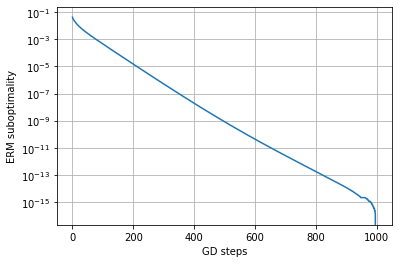

In [5]:
delta_GD = [np.linalg.norm(theta-theta_ERM) for theta in theta_list_GD]

plt.figure()
plt.plot(loss_list_GD - loss_ERM)
plt.ylabel('ERM suboptimality')
plt.xlabel('GD steps')
plt.yscale('log')
plt.grid()

## Simulations with performativity

We now simulate strategic adaptation to every single deployment of a classifier during the SGD training procedure

#### i) Define performativity model and distribution map

In [6]:
# strategic feature indices
strat_features = np.array(range(10))
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# strength of perfromativity (sensitivity parameter)
eps_list = [0.001,100.0]
    
# best response function for agents, linear utilities quadratic costs
def best_response(X, theta, epsilon, strat_features):
    
    n = X.shape[0]
    X_strat = np.copy(X)
    
    for i in range(n):
        # move everything by epsilon in the direction towards better classification
        theta_strat = theta[strat_features]
        X_strat[i, strat_features] += -epsilon * theta_strat

    return X_strat

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


#### ii) Find performatively stable point using gradient descent 

the perfromatively stable point is computed for all values of eps in *eps_list* and recorded

In [7]:
# define number of deployments for each eps separately
num_deployments = {}
num_deployments[100] = 100
num_deployments[0.001] = 10

# record results
theta_PS = {}
record_theta = {}

for c_e, eps in enumerate(eps_list):

    # initialization
    theta   = np.copy(theta_ERM)
    X_strat = np.copy(X)

    # record each theta
    record_theta[eps] = [theta]

    for k in range(num_deployments[eps]):

        X_strat = best_response(X, theta, eps, strat_features) 

        # find minimizer using GD with LS
        theta_list_gd, loss_list = run_gd(X_strat, Y, lam, tol=0, theta_init = theta, n_steps = 300)

        theta = np.copy(theta_list_gd[-1])
        record_theta[eps].append(theta)

        # compute distance between consecutive iterates
        delta_theta = np.linalg.norm(record_theta[eps][-1]-record_theta[eps][-2])

        # compute distance from ERM initialization
        delta_ERM = np.linalg.norm(theta-theta_ERM)

        print('{}: distance between iterates = {}, distance from ERM = {}'.format(k,delta_theta,delta_ERM))

    # store theta PS for all eps
    theta_PS[eps] = np.copy(theta)  
    

0: distance between iterates = 2.393169801815e-06, distance from ERM = 2.393169801815e-06
1: distance between iterates = 9.285636917275132e-09, distance from ERM = 2.399607894641406e-06
2: distance between iterates = 1.1222281345704502e-11, distance from ERM = 2.3996152541238772e-06
3: distance between iterates = 2.3278953896057584e-09, distance from ERM = 2.401130081602418e-06
4: distance between iterates = 1.4971157223498841e-09, distance from ERM = 2.402078735407125e-06
5: distance between iterates = 2.6020852139652106e-16, distance from ERM = 2.402078735406919e-06
6: distance between iterates = 1.3010426069826053e-16, distance from ERM = 2.4020787354068167e-06
7: distance between iterates = 0.0, distance from ERM = 2.4020787354068167e-06
8: distance between iterates = 0.0, distance from ERM = 2.4020787354068167e-06
9: distance between iterates = 0.0, distance from ERM = 2.4020787354068167e-06
0: distance between iterates = 0.06946057945401667, distance from ERM = 0.0694605794540166

78: distance between iterates = 1.258393267319626e-06, distance from ERM = 0.24156184193870556
79: distance between iterates = 1.123039225959236e-06, distance from ERM = 0.24156295665323563
80: distance between iterates = 4.687978994630129e-07, distance from ERM = 0.24156342414565599
81: distance between iterates = 7.1341950426625e-07, distance from ERM = 0.2415641154222809
82: distance between iterates = 4.5784838872127017e-07, distance from ERM = 0.24156456668175277
83: distance between iterates = 6.342115678975576e-07, distance from ERM = 0.24156516881291745
84: distance between iterates = 4.870492153293659e-07, distance from ERM = 0.24156564666490704
85: distance between iterates = 1.4002092289128482e-07, distance from ERM = 0.24156573576409218
86: distance between iterates = 1.3607024945217385e-07, distance from ERM = 0.24156584539483505
87: distance between iterates = 8.909025253735247e-08, distance from ERM = 0.24156587625435932
88: distance between iterates = 3.671889668496324e

c:\tools\miniconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


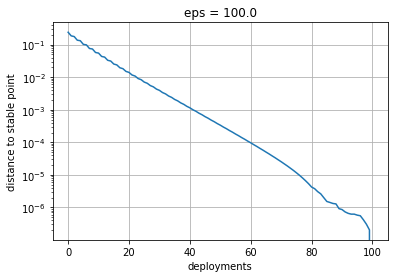

In [8]:
# visualize convergence to stable point
eps = 100.0
distance_PS = [np.linalg.norm(i-theta_PS[eps]) for i in record_theta[eps]]

plt.figure()
plt.title(strat_features)
plt.plot(distance_PS)
plt.title('eps = {}'.format(eps))
plt.xlabel('deployments')
plt.ylabel('distance to stable point')
plt.yscale('log')
plt.grid()

#### iii) Simulate convergence of different SGD methods

In [9]:
# methods to evaluate
methods = ['greedy','lazy-k','lazy-k3']

# number of epochs to simulate
num_epochs = 50

# eps values for simulation
eps_list = [0.001,100]

num_time_steps = num_epochs * n

# number of repetitions 
# note: this number needs to be increased for nice confidence intervals
num_rep = 2

record_theta_deployed = {}

for method in methods:
    print('running ', method)
    
    record_theta_deployed[method] = {}
    
    for eps in eps_list:
        
        record_theta_deployed[method][eps] = {}
        
        print('running {} eps={}'.format(method, eps), end = '')
    
        for rep in range(num_rep):
            
            print('{} '.format(rep), end = '')
            theta   = np.copy(theta_ERM)
            
            record_theta_deployed[method][eps][rep] = []

            # currently deployed classifier is the last one in the list
            theta_deployed = []

            k = 0
            t_next = 0

            # number of deployments
            for t in range(num_time_steps):

                if t == t_next:
                    
                    theta_deployed.append(theta)

                    k = k + 1
                    t_loc = 1

                    # define next deployment
                    if method == 'lazy-k':
                        t_next = t + k
                    elif method == 'lazy-k3':
                        t_next = t + k**3
                    elif method == 'greedy':
                        t_next = t + 1

                idx = np.random.randint(n)

                xi_strat = np.copy(X[idx,:])
                yi = Y[idx]

                xi_strat[strat_features] += - eps*theta_deployed[-1][strat_features]

                exp_tx   = np.exp(xi_strat @ theta)
                c        = exp_tx / (1 + exp_tx) - yi
                gradient = xi_strat * c + lam * np.append(theta[:-1], 0)

                # define stepsize sequence
                # greedy deploy
                if method == 'greedy':
                    
                    if eps <= gamma/beta:
                        c_eta = 100.0 / (gamma - eps * beta)
                        k0    = 8.0 * L**2 / (gamma - eps * beta)**2
                    else:
                        c_eta = 100.0 / gamma
                        k0    = 8.0 * L**2 / (gamma**2)
                        
                    eta   = c_eta / (k0 + t)
                
                # lazy deploy
                else: 
                    c_eta = 100.0 / gamma
                    k0    = 8.0 * L**2 / gamma**2
                    eta   = c_eta / (k0 + t_loc)  

                theta_new = theta - eta * gradient
                t_loc += 1

                theta = np.copy(theta_new)
                
                # record history of classifiers at each time step
                record_theta_deployed[method][eps][rep].append(theta_deployed[-1])

        print('')

running  greedy
running greedy eps=0.0010 1 
running greedy eps=1000 1 
running  lazy-k
running lazy-k eps=0.0010 1 
running lazy-k eps=1000 1 
running  lazy-k3
running lazy-k3 eps=0.0010 1 
running lazy-k3 eps=1000 1 


#### iv) Visualization of SGD convergence

In [10]:
# visualization with 90% confidence interval
z = 1.645

# legend entries
names = {}
names['greedy']     = 'greedy deploy'
names['lazy-k']     = r'lazy deploy, $n(k) = k$'
names['lazy-k3']    = r'lazy deploy, $n(k) = k^3$'

convergence as a function of SGD steps

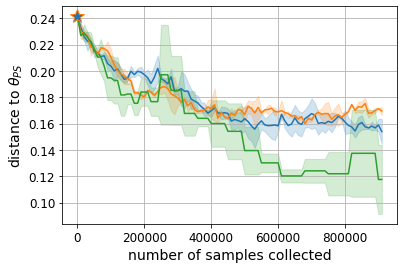

In [11]:
# pick a value of epsilon to plot
eps = 100.0

fig = plt.figure(figsize=(6,4)) 

# get color sequence
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ax     = plt.gca()

ax.tick_params(axis='both', labelsize=12)

for c_r, method in enumerate(methods):
    
    legend_entry = names[method]
    
    # subsample data to ease visualization
    x_vals = [i*10000 for i in range(int(np.ceil((num_time_steps)/10000)))]    
        
    # compute distance to stable point
    vals = np.zeros([num_rep, len(x_vals)])
    for rep in range(num_rep):
        vals[rep,:] = [np.linalg.norm(record_theta_deployed[method][eps][rep][x]-theta_PS[eps]) for x in x_vals] 

    avg_val = np.mean(vals, axis=0)
    std_val = np.std(vals, axis=0)

    # compute confidence intervals
    lb = avg_val - z*std_val/np.sqrt(num_rep)
    ub = avg_val + z*std_val/np.sqrt(num_rep)

    plt.plot(x_vals,avg_val, label = legend_entry, color = colors[c_r])
    plt.fill_between(x_vals,lb, ub, color = colors[c_r], alpha=.2)


plt.plot(0,avg_val[0], marker = '*', color = colors[1], markerfacecolor=colors[0],ms=15)

plt.xlabel('number of samples collected',fontsize = 14)
plt.ylabel(r'distance to $\theta_{PS}$',fontsize = 14)
plt.grid()

convergence as a function of the number of deployments

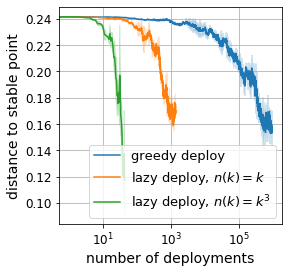

In [12]:
# print deployments
eps = 100.0

fig = plt.figure(figsize=(4,4)) 

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ax = plt.gca()

ax.tick_params(axis='both', labelsize=12)

for c_r, method in enumerate(methods):
    
    legend_entry = names[method]
          
    # find deployment times for each method
    if method == 'greedy':
        
        dt_vals = range(num_time_steps)
        
    elif method == 'lazy-k':
        
        dt_vals = []
        
        this_t = 0
        k=0
        while this_t < num_time_steps:
            k=k+1
            dt_vals.append(this_t)
            this_t = this_t+k
        
        
    elif method == 'lazy-k3':
        
        dt_vals = []
        this_t = 0
        k=0
        while this_t < num_time_steps:
            k=k+1
            dt_vals.append(this_t)
            this_t = this_t+k**3
               
    vals = np.zeros([num_rep, len(dt_vals)])

    for rep in range(num_rep):
        vals[rep,:] = [np.linalg.norm(record_theta_deployed[method][eps][rep][x]-theta_PS[eps]) for x in dt_vals] 
        
    avg_val = np.mean(vals, axis=0)
    std_val = np.std(vals, axis=0)

    # compute confidence interval
    lb = avg_val - z*std_val/np.sqrt(num_rep)
    ub = avg_val + z*std_val/np.sqrt(num_rep)
    
    plt.plot(avg_val, label = legend_entry, color = colors[c_r])
    plt.fill_between(range(len(dt_vals)),lb, ub, color = colors[c_r], alpha=.2)

    
plt.xlabel('number of deployments',fontsize = 14)
plt.ylabel('distance to stable point',fontsize = 14)
plt.grid()
plt.xscale('log')

plt.legend(fontsize = 13, loc = 'lower right')